In [51]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import csv
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
from ta import add_all_ta_features
import torch.nn.functional as F

In [53]:
# Гиперпараметры
input_size = 95
target_col_name = "close"
N = 30
seq_length = 21
batch_size = 1

In [55]:
import torch
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
import joblib
from torch.utils.data import Dataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Словарь для хранения обработанных датафреймов
all_datasets = {}
all_scalers = {}

# Проверка наличия сохраненных данных и скейлеров
processed_data_exists = os.path.exists('all_datasets.pkl')
scalers_exist = os.path.exists('all_scalers.pkl')

if processed_data_exists and scalers_exist:
    all_datasets = joblib.load('all_datasets.pkl')
    all_scalers = joblib.load('all_scalers.pkl')
    print("Загружены ранее сохраненные обработанные данные и скейлеры.")
else:
    datasets_path = "datasets"
    for file_name in os.listdir(datasets_path):
        if file_name.endswith('.csv'):
            file_path = os.path.join(datasets_path, file_name)
            dataset_name = os.path.splitext(file_name)[0]
            
                        # Пробуем разные кодировки для чтения файла
            encodings = ['utf-8', 'latin1', 'cp1251', 'iso-8859-1']
            
            for encoding in encodings:
                try:
                    df = pd.read_csv(file_path, header=None, skiprows=1, encoding=encoding)
                    break
                except UnicodeDecodeError:
                    continue
            df.drop(columns=[1, 2], inplace=True)
            df.columns = ['unix', 'open', 'high', 'low', 'close', 'VolumeBTC', 'VolumeUSD']
            
            if df.isnull().values.any():
                print(f"Обнаружены пропущенные значения в {file_name}.")
                rows_with_missing_values = df[df.isnull().any(axis=1)]
                print("Номера строк с пропущенными значениями:")
                print(rows_with_missing_values.index)
            else:
                print(f"Пропущенных значений в {file_name} не обнаружено.")
            
            df.dropna(inplace=True)
'''
Блок аугментации данных
'''
            # Масштабирование признаков
            scalers = {}
            for column in df.columns:
                scaler = MinMaxScaler()
                df[column] = scaler.fit_transform(df[column].values.reshape(-1, 1))
                scalers[column] = scaler
            
            all_datasets[dataset_name] = df
            all_scalers[dataset_name] = scalers
            
    
    joblib.dump(all_scalers, 'all_scalers.pkl')
    joblib.dump(all_datasets, 'all_datasets.pkl')
    print("Данные успешно обработаны и сохранены.")

# Получаем первый датасет из словаря
dataset_name = list(all_datasets.keys())[0]
df = all_datasets[dataset_name]

print(f"Используется датасет: {dataset_name}")

# Вычисляем точки разделения на основе длины датафрейма
total_rows = len(df)
train_size = int(0.8 * total_rows)
val_size = int(0.1 * total_rows)

# Разделяем датафрейм с сохранением временного порядка
train_df = df[:train_size]                           # Первые 80% данных
test_df = df[train_size:train_size + val_size]      # Следующие 10% данных
val_df = df[train_size + val_size:]                 # Последние 10% данных


Пропущенных значений в Bitstamp_test.csv не обнаружено.
Данные успешно обработаны и сохранены.


C:\ProgramData\anaconda3\Lib\site-packages\ta\trend.py:988: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '96443.42' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self._psar.iloc[i] = self._psar.iloc[i - 1] + (


In [7]:
class LSTM_CNN_Model(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, N, kernel_size, num_filters, dropout, seq_length):
        super(LSTM_CNN_Model, self).__init__()
        
        # LSTM layers
        self.lstm1 = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.init_weights(self.lstm1)
        
        # CNN layers
        self.conv1d = nn.Conv1d(in_channels=hidden_size, out_channels=num_filters, kernel_size=kernel_size)
        nn.init.xavier_uniform_(self.conv1d.weight)
        
        self.prelu = nn.PReLU()  # Изменение здесь
        
        # Second LSTM layer
        self.lstm2 = nn.LSTM(num_filters, hidden_size, num_layers, batch_first=True)
        self.init_weights(self.lstm2)
        
        # Fully connected layer
        self.fc = nn.Linear(hidden_size, N)
        nn.init.xavier_uniform_(self.fc.weight)
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
    
    def init_weights(self, layer):
        for name, param in layer.named_parameters():
            if 'weight_ih' in name:
                nn.init.kaiming_uniform_(param.data, nonlinearity='relu')
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param.data)
            elif 'bias' in name:
                param.data.fill_(0)
    
    def forward(self, x):
        # First LSTM forward pass
        lstm_out, _ = self.lstm1(x)
        
        # Transpose the output to fit the Conv1d input shape
        lstm_out = lstm_out.permute(0, 2, 1)
        
        # CNN forward pass
        cnn_out = self.conv1d(lstm_out)
        cnn_out = self.prelu(cnn_out)  # Изменение здесь
        
        # Transpose the output to fit the second LSTM input shape
        cnn_out = cnn_out.permute(0, 2, 1)
        
        # Second LSTM forward pass
        lstm_out, _ = self.lstm2(cnn_out)
        
        # Dropout
        lstm_out = self.dropout(lstm_out)
        
        # Fully connected layer
        lstm_out_last = lstm_out[:, -1, :]
        output = self.fc(lstm_out_last)
        output = self.prelu(output)  # Изменение здесь
        
        return output.view(output.shape[0], N)  # Reshape the output to (batch_size, N)


In [11]:
def data_generator(df, target_col_name, seq_length, batch_size, N):
    """
    Генератор для создания пакетов данных для LSTM_CNN модели.
    """
    target_col_index = df.columns.get_loc(target_col_name)
    data = df.values
    data = np.flipud(data)

    start_point = 0

    while True:  # Добавляем этот цикл, чтобы сделать генератор бесконечным
        # Создаем списки для хранения пакетов данных и меток
        batch_data = []
        batch_labels = []

        for i in range(batch_size):
            while True:
                # Извлекаем последовательность данных и соответствующую метку
                if start_point + seq_length + N <= data.shape[0]:
                    sequence = data[start_point : start_point + seq_length]
                    target = data[start_point + seq_length : start_point + seq_length + N, target_col_index]
                    # Добавляем в пакет
                    batch_data.append(sequence)
                    batch_labels.append(target)
                    start_point += 1
                    break
                else:
                    start_point = 0

        yield np.array(batch_data), np.array(batch_labels)


[[270.38662976]
 [268.14690604]
 [220.99272284]
 [162.        ]
 [214.76349126]
 [206.59449896]
 [200.09530068]
 [210.04407343]
 [217.8331126 ]
 [211.07394639]
 [228.58178667]
 [232.99124274]
 [233.02123904]
 [249.97914716]
 [253.0787648 ]
 [269.48674076]
 [262.97754372]
 [236.19084804]
 [234.74102689]
 [232.59129207]
 [217.97309533]
 [214.79348756]
 [237.96062973]
 [227.34193962]
 [226.99198279]
 [216.80323964]
 [223.36243052]
 [228.29182244]
 [224.18232938]
 [220.71275737]]


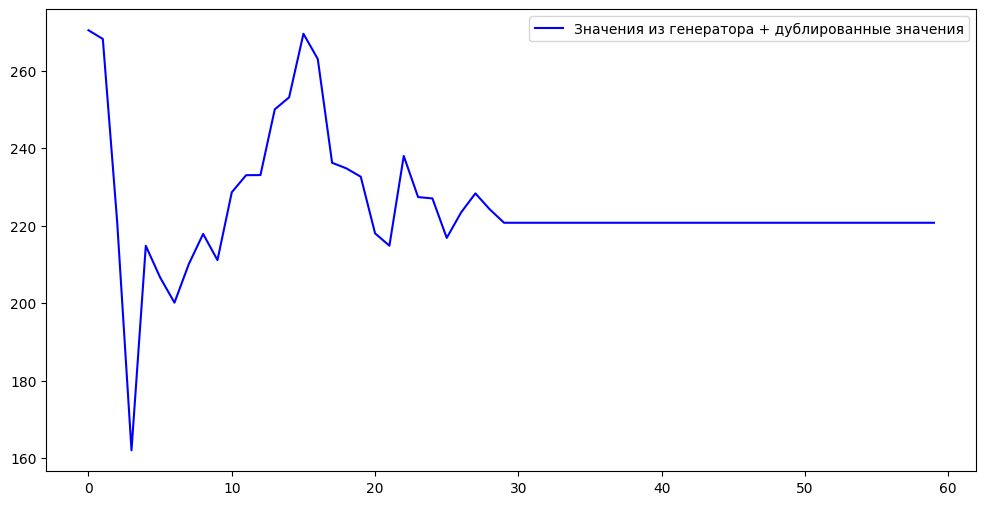

In [8]:
import matplotlib.pyplot as plt

# Генератор для тестовой выборки
val_gen = data_generator(df, target_col_name, seq_length=30, batch_size=1, N=N)

# Получаем значения из генератора
for i, (inputs, labels) in enumerate(val_gen):
    if i >= 1:
        break
    generator_values = inputs[0, :, 0]  # Предполагая, что вы хотите взять первый признак

# Применяем обратное преобразование масштабирования к значениям из генератора
generator_values_scaled_back = target_scaler.inverse_transform(generator_values.reshape(-1, 1))
print(generator_values_scaled_back)
# Создайте массив с дублированными последними значениями длиной N
duplicated_last_value = np.full(N, generator_values_scaled_back[-1])

# Создайте новый массив, объединив значения из генератора и дублированные значения
values_with_duplicated = np.concatenate((generator_values_scaled_back.flatten(), duplicated_last_value))

# Построение графика
plt.figure(figsize=(12, 6))
plt.plot(values_with_duplicated, label='Значения из генератора + дублированные значения', color='b')
plt.legend()

plt.show()


In [13]:
# Вычисляем точки разделения на основе длины датафрейма
total_rows = len(df)
train_size = int(0.8 * total_rows)
val_size = int(0.1 * total_rows)

# Разделяем DataFrame с сохранением временного порядка
train_df = df[:train_size]                           # Первые 80% данных
test_df = df[train_size:train_size + val_size]        # Следующие 10% данных
val_df = df[train_size + val_size:]                 # Последние 10% данных

# Создаем генераторы данных для каждой выборки
train_gen = data_generator(train_df, target_col_name, seq_length=seq_length, batch_size=batch_size, N=N)
val_gen = data_generator(val_df, target_col_name, seq_length=seq_length, batch_size=batch_size, N=N)
test_gen = data_generator(test_df, target_col_name, seq_length=seq_length, batch_size=batch_size, N=N)

In [14]:
# Получаем первый пакет из каждого генератора
train_data, train_labels = next(train_gen)
val_data, val_labels = next(val_gen)
test_data, test_labels = next(test_gen)



# Проверяем размеры пакетов данных и меток
print("Train data shape:", train_data.shape)
print("Train labels shape:", train_labels.shape)
print("Validation data shape:", val_data.shape)
print("Validation labels shape:", val_labels.shape)
print("Test data shape:", test_data.shape)
print("Test labels shape:", test_labels.shape)

# Проверяем, что метки соответствуют данным
assert train_data.shape[0] == train_labels.shape[0], "Number of examples does not match for training data and labels"
assert val_data.shape[0] == val_labels.shape[0], "Number of examples does not match for validation data and labels"
assert test_data.shape[0] == test_labels.shape[0], "Number of examples does not match for test data and labels"

assert train_data.shape[1] == seq_length, "Sequence length does not match for training data"
assert val_data.shape[1] == seq_length, "Sequence length does not match for validation data"
assert test_data.shape[1] == seq_length, "Sequence length does not match for test data"

assert train_labels.shape[1] == N, "Target length does not match for training labels"
assert val_labels.shape[1] == N, "Target length does not match for validation labels"
assert test_labels.shape[1] == N, "Target length does not match for test labels"

    # Проверяем на NaNs и бесконечные значения
assert not np.isnan(train_data).any(), "Training data contains NaNs"
assert not np.isinf(train_data).any(), "Training data contains infinite values"
assert not np.isnan(train_labels).any(), "Training labels contain NaNs"
assert not np.isinf(train_labels).any(), "Training labels contain infinite values"

assert not np.isnan(val_data).any(), "Validation data contains NaNs"
assert not np.isinf(val_data).any(), "Validation data contains infinite values"
assert not np.isnan(val_labels).any(), "Validation labels contain NaNs"
assert not np.isinf(val_labels).any(), "Validation labels contain infinite values"

assert not np.isnan(test_data).any(), "Test data contains NaNs"
assert not np.isinf(test_data).any(), "Test data contains infinite values"
assert not np.isnan(test_labels).any(), "Test labels contain NaNs"
assert not np.isinf(test_labels).any(), "Test labels contain infinite values"

print("All checks passed!")

Train data shape: (1, 30, 95)
Train labels shape: (1, 30)
Validation data shape: (1, 30, 95)
Validation labels shape: (1, 30)
Test data shape: (1, 30, 95)
Test labels shape: (1, 30)
All checks passed!


МОДЕЛЬ ОБУЧАЕТСЯ ДАЛЕЕ

In [ ]:
import torch
import torch.optim as optim
import optuna
import math
import json
import gc
import time
import copy
import torch.optim.lr_scheduler as lr_scheduler
import torch.nn as nn
import numpy as np
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from collections import deque
from torch.cuda.amp import autocast, GradScaler

N = 30

def objective(trial):
    try:
        # Задаем гиперпараметры
        num_layers = trial.suggest_int('num_layers', 1, 3)
        hidden_size = trial.suggest_int('hidden_size', 128, 1024)
        dropout = trial.suggest_float('dropout', 0.1, 0.8)
        num_filters = trial.suggest_int('num_filters', 128, 1024)
        kernel_size = trial.suggest_int('kernel_size', 2, 7)
        learning_rate = trial.suggest_float('lr', 1e-3, 1e-3, log=True)
        seq_length = trial.suggest_int('seq_length', 1, 150)
        batch_size = trial.suggest_int('batch_size', 4000, 4000)
        weight_decay = trial.suggest_float('weight_decay', 0.001, 0.8)
        train_steps = trial.suggest_int('train_steps', 1, 1)
        num_epochs = trial.suggest_int('num_epochs', 400, 400)
        criterion_name = trial.suggest_categorical('criterion', ['MSELoss', 'SmoothL1Loss'])
        
        num_val_steps = 15
        result_val_steps = 600
        loss_diff_percent = 0.05
        avg_loss_percent = 0.00
        squiz = 3
        early_stopping_patience = 10  # Количество эпох для ранней остановки

        # TensorBoard writer
        writer = SummaryWriter()

        # Создаем генераторы для каждой выборки
        train_gen = data_generator(train_df, target_col_name, seq_length=seq_length, batch_size=batch_size, N=N)
        val_gen = data_generator(val_df, target_col_name, seq_length=seq_length, batch_size=batch_size, N=N)
        test_gen = data_generator(test_df, target_col_name, seq_length=seq_length, batch_size=batch_size, N=N)

        model = LSTM_CNN_Model(input_size, hidden_size, num_layers, N, kernel_size, num_filters, dropout, seq_length).to(device)

        if criterion_name == 'MSELoss':
            criterion = nn.MSELoss()
        else:
            criterion = nn.SmoothL1Loss()
        
        optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=5, min_lr=1e-7)

        total_examples = len(train_df)
        total_steps = math.ceil(total_examples / batch_size)
        val_losses = []

        # Инициализируем переменные для аккумуляции градиентов
        optimizer.zero_grad()
        accumulated_loss = torch.zeros(1, device=device)
        best_model = None
        best_avg_loss = float('inf')
        avg_loss = float('inf')
        losses = []
        epochs_no_improve = 0
        start_time = time.time()
        scaler = GradScaler()

        for epoch in range(num_epochs):
            print(f"Начало эпохи {epoch+1}")
            model.train()
            epoch_train_loss = 0
            epoch_r2_score = 0
            epoch_mae = 0
            epoch_rmse = 0

            for i, (inputs, labels) in enumerate(train_gen):
                inputs = torch.from_numpy(inputs).float().to(device)
                labels = torch.from_numpy(labels).float().to(device)

                with autocast():
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    accumulated_loss += loss

                if (i+1) % train_steps == 0 or (i+1) == total_steps:
                    predicted_values = outputs.detach().cpu().numpy()
                    target_values = labels.detach().cpu().numpy()
                    predicted_values_scaled_back = target_scaler.inverse_transform(predicted_values)
                    target_values_scaled_back = target_scaler.inverse_transform(target_values)
                    print(f"Предсказанные значения при обучении МАСШТАБ: {predicted_values_scaled_back[:1]}")
                    print(f"Целевые значения при обучении МАСШТАБ: {target_values_scaled_back[:1]}")

                    accumulated_loss /= train_steps
                    scaler.scale(accumulated_loss).backward()
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                    scaler.step(optimizer)
                    scaler.update()
                    optimizer.zero_grad()
                    accumulated_loss = torch.zeros(1, device=device)

                    epoch_train_loss += loss.item()
                    if target_values.shape[0] > 1:
                        epoch_r2_score += r2_score(target_values, predicted_values)
                    epoch_mae += mean_absolute_error(target_values, predicted_values)
                    epoch_rmse += np.sqrt(mean_squared_error(target_values, predicted_values))

                    model.eval()
                    with torch.no_grad():
                        val_loss = 0
                        val_r2_score = 0
                        val_mae = 0
                        val_rmse = 0

                        for j, (val_inputs, val_labels) in enumerate(val_gen):
                            if j >= num_val_steps:
                                break
                            val_inputs = torch.from_numpy(val_inputs).float().to(device)
                            val_labels = torch.from_numpy(val_labels).float().to(device)

                            with autocast():
                                val_outputs = model(val_inputs)
                                val_loss += criterion(val_outputs, val_labels).item()

                            val_predicted_values = val_outputs.detach().cpu().numpy()
                            val_target_values = val_labels.detach().cpu().numpy()
                            val_predicted_values_scaled_back = target_scaler.inverse_transform(val_predicted_values)
                            val_target_values_scaled_back = target_scaler.inverse_transform(val_target_values)

                            if val_target_values.shape[0] > 1:
                                val_r2_score += r2_score(val_target_values, val_predicted_values)
                            val_mae += mean_absolute_error(val_target_values, val_predicted_values)
                            val_rmse += np.sqrt(mean_squared_error(val_target_values, val_predicted_values))

                        val_loss /= num_val_steps
                        if num_val_steps > 1:
                            val_r2_score /= num_val_steps
                        val_mae /= num_val_steps
                        val_rmse /= num_val_steps
                        print("Потери на валидационной выборке:", val_loss)
                    model.train()
                    losses.append(val_loss)

                    if len(losses) > squiz:
                        losses.pop(0)
                    current_avg_loss = sum(losses) / len(losses)

                    step = epoch * total_steps + i
                    writer.add_scalar('Training Loss', loss.item(), step)
                    writer.add_scalar('Validation Loss', val_loss, step)
                    if target_values.shape[0] > 1:
                        writer.add_scalar('Training R2 Score', epoch_r2_score / total_steps, step)
                        writer.add_scalar('Validation R2 Score', val_r2_score, step)
                    writer.add_scalar('Training MAE', epoch_mae / total_steps, step)
                    writer.add_scalar('Validation MAE', val_mae, step)
                    writer.add_scalar('Training RMSE', epoch_rmse / total_steps, step)
                    writer.add_scalar('Validation RMSE', val_rmse, step)

                    if len(losses) == squiz:
                        if current_avg_loss < avg_loss:
                            avg_loss = current_avg_loss
                            print("Потери обучения:", avg_loss)
                            best_model = copy.deepcopy(model.state_dict())

                    print('Epoch [{}/{}], Step [{}/{}], Loss: {:.10f}'.format(epoch+1, num_epochs, i+1, total_steps, loss.item()))

                if (i+1) >= total_steps: 
                    break

                del inputs, labels, outputs, loss
                gc.collect()

            scheduler.step(val_loss)

            if current_avg_loss < best_avg_loss:
                best_avg_loss = current_avg_loss
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1

            elapsed_time = time.time() - start_time
            estimated_time = (elapsed_time / (epoch + 1)) * (num_epochs - (epoch + 1))
            print(f"Примерное время до окончания обучения: {estimated_time // 60:.0f} минут {estimated_time % 60:.0f} секунд")

            if epochs_no_improve >= early_stopping_patience:
                print("Ранняя остановка!")
                break

        model.load_state_dict(best_model)
        print('Потери для текущей модели', best_avg_loss)

        # Валидация
        print("Начало валидации")
        val_loss = 0
        val_steps = 0
        model.eval()
        val_r2_score = 0
        val_mae = 0
        val_rmse = 0

        with torch.no_grad():
            for i, (inputs, labels) in enumerate(val_gen):
                if i >= result_val_steps:
                    break
                inputs = torch.from_numpy(inputs).float().to(device)
                labels = torch.from_numpy(labels).float().to(device)

                with autocast():
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                val_loss += loss.item()
                val_steps += 1

                predicted_values = outputs.detach().cpu().numpy()
                target_values = labels.detach().cpu().numpy()

                if target_values.shape[0] > 1:
                    val_r2_score += r2_score(target_values, predicted_values)
                val_mae += mean_absolute_error(target_values, predicted_values)
                val_rmse += np.sqrt(mean_squared_error(target_values, predicted_values))

                del inputs, labels, outputs, loss
                gc.collect()
                torch.cuda.empty_cache()

        print("Конец валидации")
        avg_val_loss = val_loss / val_steps
        if val_steps > 1:
            avg_val_r2_score = val_r2_score / val_steps
        else:
            avg_val_r2_score = float('nan')
        avg_val_mae = val_mae / val_steps
        avg_val_rmse = val_rmse / val_steps
        print(avg_val_loss, avg_val_r2_score, avg_val_mae, avg_val_rmse)
        val_losses.append(avg_val_loss)

        writer.add_hparams(trial.params, {
            'hparam/validation_loss': avg_val_loss,
            'hparam/validation_r2_score': avg_val_r2_score,
            'hparam/validation_mae': avg_val_mae,
            'hparam/validation_rmse': avg_val_rmse
        })

        writer.close()

        if trial.number == 0 or avg_val_loss < study.best_value:
            torch.save(model.state_dict(), 'best_model.pth')
            with open('best_params.json', 'w') as f:
                json.dump(trial.params, f)
        return np.mean(val_losses)

    except RuntimeError as e:
        if "out of memory" in str(e):
            print("Out of memory error caught. Skipping this configuration.")
            return 1000000
    except Exception as e:
        print(f"Unexpected error: {str(e)}. Skipping this configuration.")
        return 9999999

try:
    study = optuna.load_study(study_name='bitcoin_prediction', storage='sqlite:///bitcoin_prediction.db')
except:
    study = optuna.create_study(direction='minimize', study_name='bitcoin_prediction', storage='sqlite:///bitcoin_prediction.db')

study.optimize(objective, n_trials=9999999999)

print('Best trial:')
trial = study.best_trial
print('  Value: ', trial.value)
print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))


In [9]:
# Загрузка сохраненных данных и скейлеров
all_datasets = joblib.load('all_datasets.pkl')
all_scalers = joblib.load('all_scalers.pkl')

# Выбор конкретного датасета 
dataset_name = list(all_datasets.keys())[0]
df = all_datasets[dataset_name]
scalers = all_scalers[dataset_name]

# Получаем нужный скейлер для целевой переменной
target_scaler = scalers['close'] 
target_col_name = 'close'


In [11]:
def data_generator(df, target_col_name, seq_length, batch_size, N):
    """
    Генератор для создания пакетов данных для LSTM_CNN модели.
    """
    target_col_index = df.columns.get_loc(target_col_name)
    data = df.values
    data = data[:seq_length]
    
    while True:
        batch_data = []
        batch_labels = []
        
        for i in range(batch_size):
            if seq_length <= data.shape[0]:
                sequence = data[0:seq_length]
                target = data[-1, target_col_index]
            else:
                return
                
            batch_data.append(sequence)
            batch_labels.append(target)
            
        yield np.array(batch_data), np.array(batch_labels)

In [57]:
# Загрузка наилучших гиперпараметров
with open('best_params.json', 'r') as f:
    best_params = json.load(f)
input_size = 95
# Загрузка модели с наилучшими параметрами
best_model = LSTM_CNN_Model(input_size, best_params['hidden_size'], best_params['num_layers'], N, best_params['kernel_size'], best_params['num_filters'], best_params['dropout'], best_params['seq_length']).to(device)
best_model.load_state_dict(torch.load('best_model.pth'))

# Переводим модель в режим оценки
best_model.eval()

test_loss = 0
test_steps = 0
criterion = nn.SmoothL1Loss()#MSELoss()#SmoothL1Loss()

target_outputs = []
target_labels = []

# Генератор для тестовой выборки
val_gen = data_generator(df, target_col_name, seq_length=best_params['seq_length'], batch_size=1, N=N)

with torch.no_grad():
    for i, (inputs, labels) in enumerate(val_gen):
        if i >= 1:
            break
        print(f"Размер входных данных: {inputs.shape}")
        print(f"Размер меток: {labels.shape}")
        inputs = torch.from_numpy(inputs).float().to(device)

        # Получение предсказаний модели
        outputs = best_model(inputs)

        # Преобразование тензоров обратно в numpy массивы для вывода
        predicted_values = outputs.detach().cpu().numpy()  # Переводим тензор в numpy массив
        predicted_values_scaled_back = target_scaler.inverse_transform(predicted_values)

        print(f"Предсказанные значения  МАСШТАБ: {predicted_values_scaled_back[:1]}")  # Вывод предсказаний


Размер входных данных: (1, 21, 95)
Размер меток: (1,)
Предсказанные значения  МАСШТАБ: [[67064.164 67622.305 67203.6   69611.516 68885.59  72754.42  69543.22
  71731.62  70526.79  70571.85  73584.11  72988.48  72299.695 72927.75
  74566.4   74782.82  75316.81  75017.93  74809.69  73023.266 75203.445
  73518.664 73254.54  76477.65  75860.27  76608.98  76563.44  78039.5
  78819.195 77102.89 ]]


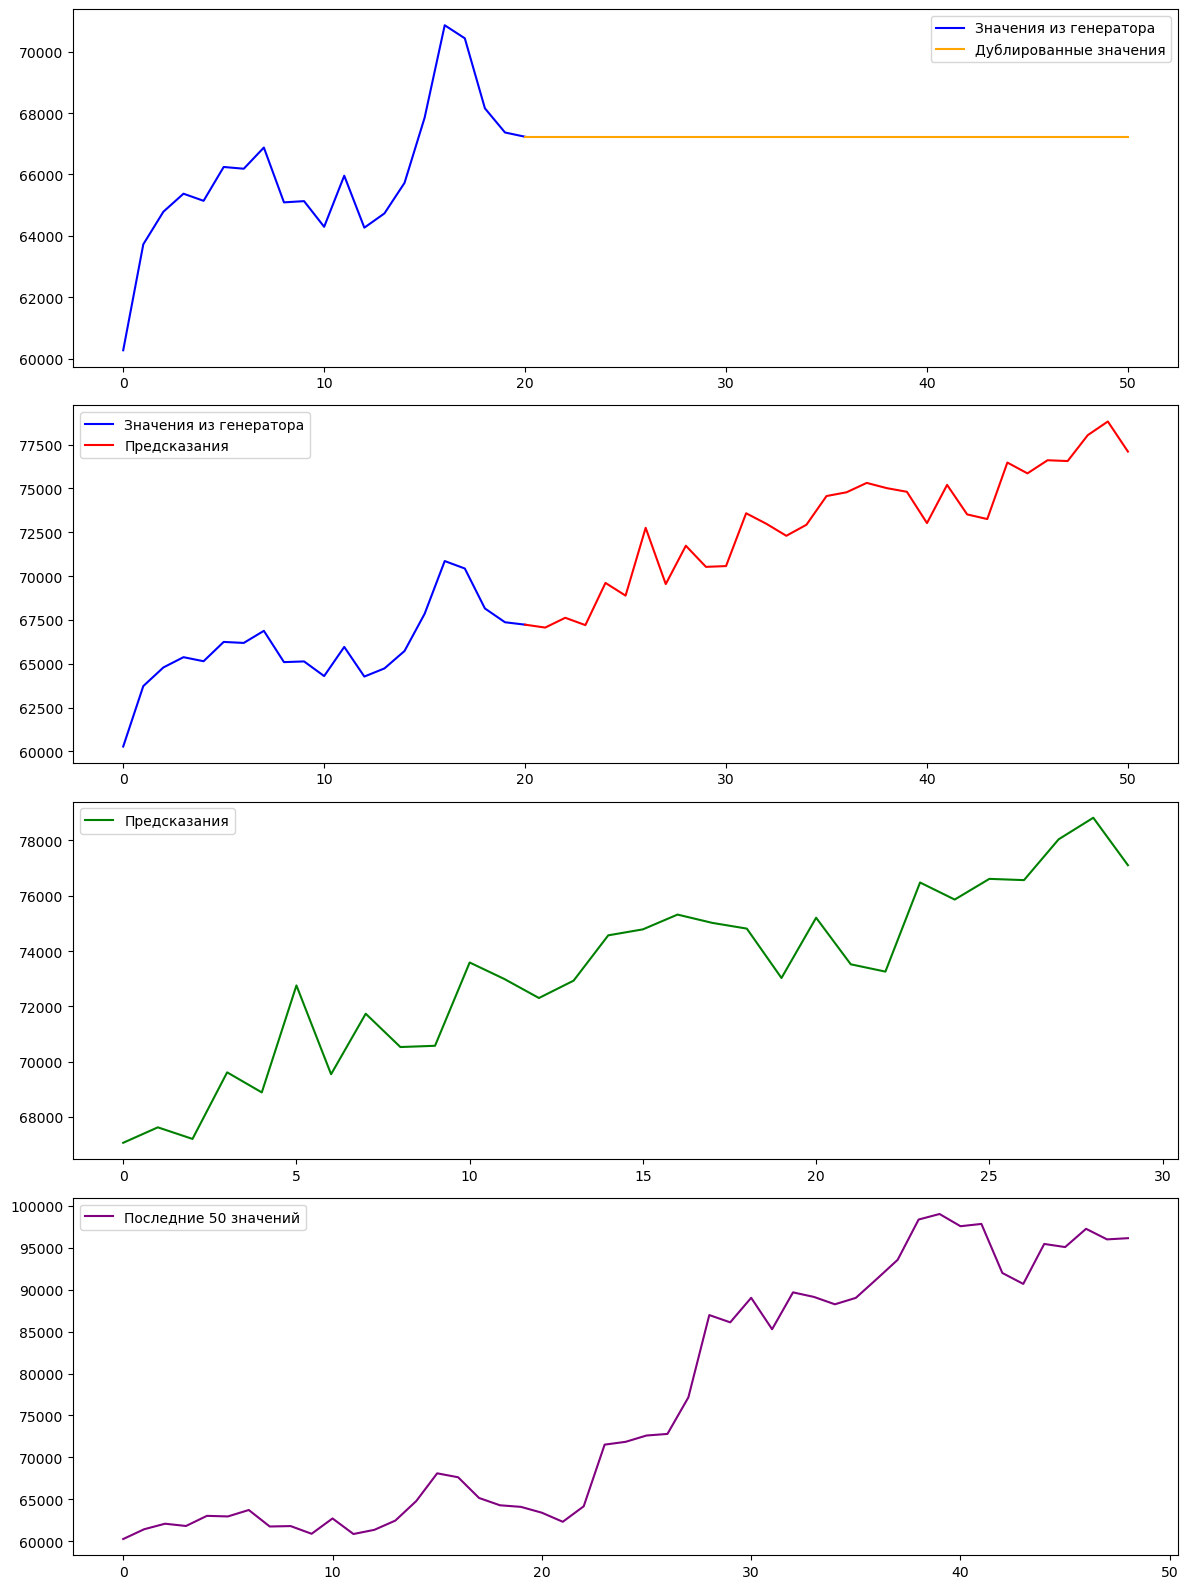

In [59]:
import matplotlib.pyplot as plt
import numpy as np

# Генератор для тестовой выборки
val_gen = data_generator(df, target_col_name, seq_length=best_params['seq_length'], batch_size=1, N=N)

# Получаем значения из генератора
for i, (inputs, labels) in enumerate(val_gen):
    if i >= 1:
        break
    generator_values = inputs[0, :, 0]

# Применяем обратное преобразование масштабирования к значениям из генератора
generator_values_scaled_back = target_scaler.inverse_transform(generator_values.reshape(-1, 1))

# Создайте массив с дублированными последними значениями длиной N
duplicated_last_value = np.full(N, generator_values_scaled_back[-1])

# Создайте новый массив, объединив значения из генератора и дублированные значения
values_with_duplicated = np.concatenate((generator_values_scaled_back.flatten(), duplicated_last_value))

# Создайте новый массив, объединив значения из генератора и предсказания
values_with_predictions = np.concatenate((generator_values_scaled_back.flatten(), predicted_values_scaled_back.flatten()))

# Получаем 50 значений с конца и применяем обратное масштабирование
last_50_values = df[target_col_name].iloc[-50:].values
last_50_values_scaled_back = target_scaler.inverse_transform(last_50_values.reshape(-1, 1))

# Построение графиков
plt.figure(figsize=(12, 16))

# Первый график (с разными цветами)
plt.subplot(4, 1, 1)
plt.plot(generator_values_scaled_back, label='Значения из генератора', color='b')
plt.plot(range(len(generator_values_scaled_back)-1, len(values_with_duplicated)), 
         values_with_duplicated[len(generator_values_scaled_back)-1:], 
         label='Дублированные значения', color='orange')
plt.legend()

# Второй график (с разными цветами)
plt.subplot(4, 1, 2)
plt.plot(generator_values_scaled_back, label='Значения из генератора', color='b')
plt.plot(range(len(generator_values_scaled_back)-1, len(values_with_predictions)), 
         values_with_predictions[len(generator_values_scaled_back)-1:], 
         label='Предсказания', color='r')
plt.legend()

# Третий график
plt.subplot(4, 1, 3)
plt.plot(predicted_values_scaled_back[0], label='Предсказания', color='g')
plt.legend()

# В секции построения графиков меняем последний график:
plt.subplot(4, 1, 4)
plt.plot(last_50_values_scaled_back, label='Последние 50 значений', color='purple')
plt.legend()

plt.tight_layout()
plt.show()
